# Does Enhancing Images also Enhance the Outcome of Image Recognition of Neural Networks

# General Layout for this program

1. Imports
2. Load the training set
3. Load in the test set
4. Load in the test set labels
5. Create a copy of the image set and apply CLAHE to it
6. Load in 2 pretrained resnets
7. Train resnet1 on OG images, train resnet2 on CLAHE images
8. Compare performance of both

# Imports

In [2]:
import torch
from torchvision import *
from torch import optim
import torch.nn as nn
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import os
from PIL import Image
from timeit import default_timer as timer
import cv2

# Create the Transforms

In [3]:
from statistics import mean


input_shape = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

# Open the ImageNet Spotted Salamanders
Loop through the imagenet training directory pulling in all 1200 Spotted Salamader images. Then create a copy of the images and label it CLAHE

Length of set = 1150


/var/folders/yw/ckylxvy95xld6whm7608ymr80000gn/T/ipykernel_11435/4074599817.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


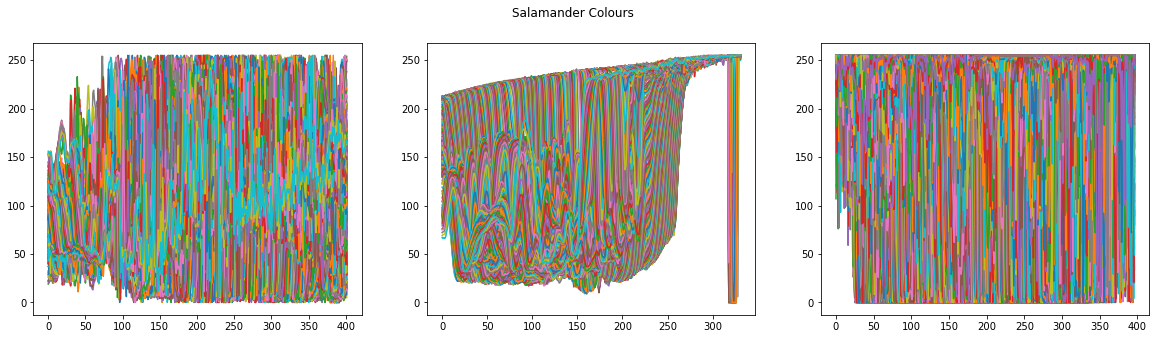

In [4]:
trainSetOG = []

directory = 'imageNet/ILSVRC/Data/CLS-LOC/train/n01632458/'

#Load in all salamader images
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        #trainSetOG.append(cv2.imread(f, 0))
        trainSetOG.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))

#copy it 
trainSetCLAHE = trainSetOG

print('Length of set = ' + str(len(trainSetCLAHE)))

cv2.imshow('image', trainSetOG[0])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize = (20, 5))

fig.suptitle('Salamander Colours')
ax1.plot(trainSetOG[0])
ax2.plot(trainSetOG[1])    
ax3.plot(trainSetOG[2])
fig.show()

# Practice transforming

In [5]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

/Users/ian/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ian/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from torch.utils.data import Dataset, DataLoader


Get the shapes of the images for normalization


In [7]:
smallestHeight = 1000
smallestWidth = 1000
largestHeight = 0
largestWidth = 0

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        #trainSetOG.append(cv2.imread(f, 0))
        img = cv2.imread(f)

        if img.shape[0] < smallestHeight:
            smallestHeight = img.shape[0]
        if img.shape[1] < smallestWidth:
            smallestWidth = img.shape[1]
        if img.shape[0] > largestHeight:
            largestHeight = img.shape[0]
        if img.shape[1] > largestWidth:
            largestWidth = img.shape[1]


print('Smallest Height = ' + str(smallestHeight))
print('Smallest Width = ' + str(smallestWidth))
print('Largest Height = ' + str(largestHeight))
print('Largest Width = ' + str(largestWidth))

Smallest Height = 52
Smallest Width = 80
Largest Height = 2379
Largest Width = 2048


In [14]:
import torchvision
import numpy
from torchvision import transforms
transforms = transforms.Compose(
[
   transforms.ToTensor(),
   transforms.Normalize(mean, std),
   transforms.Resize((smallestHeight, smallestWidth))
   #transforms.Pad((largestHeight - smallestHeight, largestWidth - smallestWidth))
   #transforms.Pad(3300, 2500)
])

directory = 'imageNet/ILSVRC/Data/CLS-LOC/train/n01632458/'
train_dataset = torchvision.datasets.ImageFolder('imageNet/ILSVRC/Data/CLS-LOC/train/sals/', transforms)

print(type(train_dataset))
print(type([train_dataset[0]]))

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [10]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
net = models.resnet18(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
device = 'cpu'


In [12]:
# for i in range(10):
#     tensor = train_dataset[i]
#     print(type(tensor[0]))
#     print(tensor[0].shape)
#     print(tensor[1])

In [13]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    batch_idx = -1
    for data_, target_ in train_loader:
        batch_idx += 1

        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        print(outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (train_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(train_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

tensor([[-1.3024,  0.0204, -0.0763,  ..., -0.1401, -0.8632,  0.0022],
        [-0.4519,  0.8004, -0.1671,  ..., -0.5256, -0.2575,  0.4250],
        [-0.3424,  0.3859,  0.0865,  ..., -0.1830, -0.3890, -0.2716],
        ...,
        [-0.4012,  0.4895, -0.0884,  ..., -0.2474, -1.1892, -0.2684],
        [-0.6140,  0.6092, -0.2484,  ..., -0.4399, -0.8183,  0.3306],
        [-0.9915,  1.0271,  0.4393,  ..., -0.2432, -1.2135, -0.4385]],
       grad_fn=<AddmmBackward0>)
Epoch [1/5], Step [0/13], Loss: 5.6575
tensor([[-0.4723,  2.0833,  1.0063,  ..., -0.9836, -0.8762,  1.1189],
        [-0.6677,  0.4273, -0.7166,  ..., -0.6702,  0.1939, -0.7802],
        [-0.4005,  1.9769,  0.3640,  ..., -1.6101, -1.4457,  0.5720],
        ...,
        [ 0.4228,  0.9107, -0.1989,  ..., -1.0140, -1.1745, -0.0286],
        [-0.3338,  0.7825, -0.0481,  ..., -0.1598, -0.2429, -0.2489],
        [-0.6342,  2.9687,  1.5709,  ..., -0.3779, -0.6302, -1.0983]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2712, 

KeyboardInterrupt: 